<a href="https://colab.research.google.com/github/majdsuleiman98/Semantic-Based-Product-Recommendations-with-Vector-Databases-and-Large-Language-Models/blob/main/NLP_Based_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain transformers sentence-transformers faiss-cpu langchain_community

In [ ]:
import faiss
import textwrap
import numpy as np
import pandas as pd
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [ ]:
import pandas as pd
data = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv",on_bad_lines='skip')
data.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
data.shape

(44424, 10)

In [ ]:
def print_img(img_id):
    im = Image.open(f"/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/{img_id}.jpg")
    plt.imshow(im)
    plt.axis("off")
    plt.show()

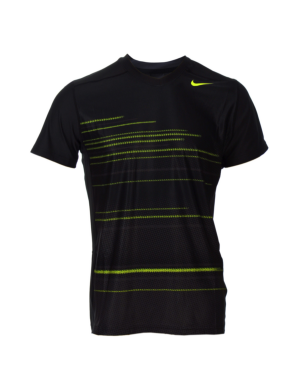

In [ ]:
print_img(10010)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(44077, 10)

In [ ]:
def create_descriptions(data):
    descriptions = list()
    metadata = list()
    for index,product in data.iterrows():
        description = (
            f"{product['productDisplayName']} is a {product['usage']} {product['season'].lower()} {product['articleType'].lower()} for {product['gender'].lower()}, "
            f"part of the {product['masterCategory'].lower()} category, with a {product['baseColour'].lower()} dial and base color, "
            f"released in {int(product['year'])}."
        )
        descriptions.append(description)
        metadata.append({'img_id':product['id']})

    return descriptions, metadata

In [ ]:
descriptions, metadata = create_descriptions(data)
ids = [str(id) for id in range(len(descriptions))]

In [ ]:
for id, img_id, description in list(zip(ids,metadata,descriptions))[:5]:
    print(id)
    print(img_id)
    print(description)
    print("-"*100)

0
{'img_id': 15970}
Turtle Check Men Navy Blue Shirt is a Casual fall shirts for men, part of the apparel category, with a navy blue dial and base color, released in 2011.
----------------------------------------------------------------------------------------------------
1
{'img_id': 39386}
Peter England Men Party Blue Jeans is a Casual summer jeans for men, part of the apparel category, with a blue dial and base color, released in 2012.
----------------------------------------------------------------------------------------------------
2
{'img_id': 59263}
Titan Women Silver Watch is a Casual winter watches for women, part of the accessories category, with a silver dial and base color, released in 2016.
----------------------------------------------------------------------------------------------------
3
{'img_id': 21379}
Manchester United Men Solid Black Track Pants is a Casual fall track pants for men, part of the apparel category, with a black dial and base color, released in 2011.

In [ ]:
model_id = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    device_map="auto",
)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    num_beams=5,
    temperature=0.0,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    do_sample=False,
    max_new_tokens=30
)

llm = HuggingFacePipeline(pipeline=pipe)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
embedding_model = SentenceTransformer(model_id,device="cuda")

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
embeddings = embedding_model.encode(descriptions,show_progress_bar=True)

Batches:   0%|          | 0/1378 [00:00<?, ?it/s]

In [ ]:
print(descriptions[100])
print(metadata[100])
print(ids[100])
print(embeddings[100])
print(len(embeddings[100]))

Nike Men Air Rift MTR White Casual Shoe is a Casual fall casual shoes for men, part of the footwear category, with a white dial and base color, released in 2011.
{'img_id': 19311}
100
[-0.02718328 -0.01112214  0.04643658 ...  0.0473819  -0.01286388
 -0.02409892]
1024


In [ ]:
def Indexing(embeddings, ids, dim):
    normalized_embeddings = deepcopy(embeddings)
    faiss.normalize_L2(normalized_embeddings)
    faiss_index = faiss.IndexIDMap(faiss.IndexFlatIP(dim))
    faiss_index.add_with_ids(normalized_embeddings,ids)
    return faiss_index

In [ ]:
dim = len(embeddings[0])
faiss_index = Indexing(embeddings, ids, dim)

In [ ]:
def similarity_search(query,top_k=10):
    query_encode = embedding_model.encode([query])
    faiss.normalize_L2(query_encode)
    results = faiss_index.search(query_encode,top_k)
    return results

In [ ]:
query = "I'm looking for a casual black men's shirt for fall."
results = similarity_search(query)
print(results)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(array([[0.6344714 , 0.6339673 , 0.6339673 , 0.63248134, 0.63164616,
        0.63022304, 0.6301087 , 0.62982893, 0.62801003, 0.6277792 ]],
      dtype=float32), array([[ 7534, 43796, 40100, 35551, 32364, 16591, 35795, 10455, 18224,
        18454]]))


In [ ]:
def retrive_data(results):
    img_ids = []
    retrived_descriptions = []
    for id in results[1][0]:
        img_id = metadata[id]["img_id"]
        descrpiton = descriptions[id]
        img_ids.append(img_id)
        retrived_descriptions.append(descrpiton)

    return retrived_descriptions, img_ids

In [ ]:
query = "I'm looking for a casual black men's shirt for fall."

retrived_descriptions, retrived_img_ids = retrive_data(similarity_search(query))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

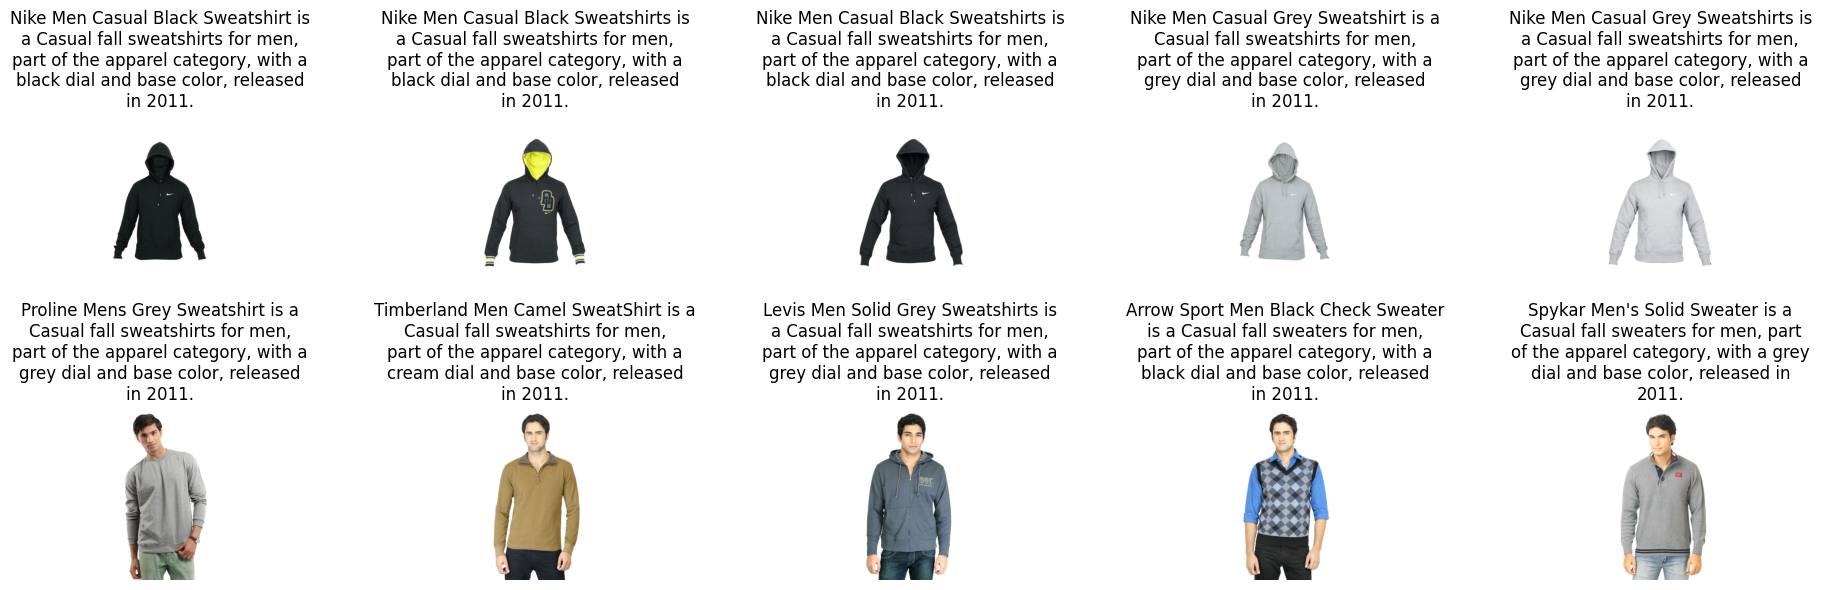

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))

for i, (img_id,description) in enumerate(zip(retrived_img_ids,retrived_descriptions)):
    img = Image.open(f"/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/{img_id}.jpg")
    row, col = divmod(i, 5)
    axes[row, col].imshow(img)
    axes[row, col].set_title(textwrap.fill(description,36))
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
products_for_llm = "\n".join([f"img_id: {img_id}, description: {description}"
                              for img_id, description in zip(retrived_img_ids, retrived_descriptions)])


In [ ]:
print(products_for_llm)

img_id: 17905, description: Nike Men Casual Black Sweatshirt is a Casual fall sweatshirts for men, part of the apparel category, with a black dial and base color, released in 2011.
img_id: 15598, description: Nike Men Casual Black Sweatshirts is a Casual fall sweatshirts for men, part of the apparel category, with a black dial and base color, released in 2011.
img_id: 15599, description: Nike Men Casual Black Sweatshirts is a Casual fall sweatshirts for men, part of the apparel category, with a black dial and base color, released in 2011.
img_id: 17913, description: Nike Men Casual Grey Sweatshirt is a Casual fall sweatshirts for men, part of the apparel category, with a grey dial and base color, released in 2011.
img_id: 15600, description: Nike Men Casual Grey Sweatshirts is a Casual fall sweatshirts for men, part of the apparel category, with a grey dial and base color, released in 2011.
img_id: 13800, description: Proline Mens Grey Sweatshirt is a Casual fall sweatshirts for men, p

In [ ]:
template = """
Using the following product descriptions with img_ids, recommend only the most relevant products for user needs.
Consider the style, practicality, and suitability of each item according to the user's specific need.

# Example 1
Product Descriptions:
img_id: 101, description: Red winter jacket, stylish and warm.
img_id: 102, description: Blue summer shirt, light and breathable.
img_id: 103, description: Black casual hoodie, versatile for all seasons.

User Need:
Looking for a warm, stylish winter jacket.

Recommendations (list only the img_id values of the recommended products):
101

# Example 2
Product Descriptions:
img_id: 201, description: Grey athletic shoes, perfect for running.
img_id: 202, description: Casual leather shoes for everyday wear.
img_id: 203, description: Formal black dress shoes, suitable for office.

User Need:
Looking for everyday shoes, not too formal, comfortable for walking.

Recommendations (list only the img_id values of the recommended products):
202

# Now respond to the following request based on the new products and user need:

# Product Descriptions:
{retrieved_products}

# User Need:
{query}

# Recommendations (list only the img_id values of recommended products that best match the user's need, separated by commas, with no additional text):
"""

promptTemplate = PromptTemplate(template=template,input_variables=["retrieved_products","query"])
prompt = promptTemplate.format(retrieved_products=products_for_llm,query=query)

In [ ]:
responses = llm(prompt)

Token indices sequence length is longer than the specified maximum sequence length for this model (811 > 512). Running this sequence through the model will result in indexing errors
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-05` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
responses

'Nike Men Casual Black Sweatshirt img_id: 17905'

In [ ]:
recommended_img_ids = re.findall(r'\d+', responses)

In [ ]:
recommended_img_ids

['17905']

I'm looking for a casual black men's shirt for fall.


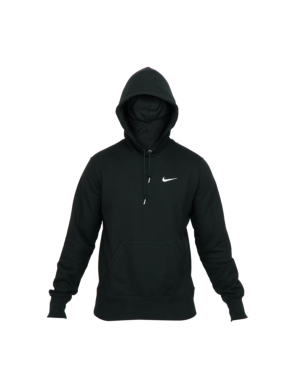

In [ ]:
print(query)
print_img(recommended_img_ids[0])

In [ ]:
data[data["id"] == recommended_img_ids[0]]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
7602,17905,Men,Apparel,Topwear,Sweatshirts,Black,Fall,2011.0,Casual,Nike Men Casual Black Sweatshirt
